# Cointegration Tests & Pairs Trading

## What is cointegration?
We have seen how a time series can have a unit root that creates a stochastic trend and makes the time series highly persistent. When we use such an integrated time series in their original, rather than in differenced, form as a feature in a linear regression model, its relationship with the outcome will often appear statistically significant, even though it is not. This phenomenon is called spurious regression (for details, see Chapter 18 in [Wooldridge, 2008](https://economics.ut.ac.ir/documents/3030266/14100645/Jeffrey_M._Wooldridge_Introductory_Econometrics_A_Modern_Approach__2012.pdf)). Therefore, the recommended solution is to difference the time series so they become stationary before using them in a model.

However, there is an exception when there are cointegration relationships between the outcome and one or more input variables. To understand the concept of cointegration, let's first remember that the residuals of a regression model are a linear combination of the inputs and the output series.

Usually, the residuals of the regression of one integrated time series on one or more such series yields non-stationary residuals that are also integrated, and thus behave like a random walk. However, for some time series, this is not the case: the regression produces coefficients that yield a linear combination of the time series in the form of the residuals that are stationary, even though the individual series are not. Such time series are
cointegrated.

A non-technical example is that of a drunken man on a random walk accompanied by his dog (on a leash). Both trajectories are non-stationary but cointegrated because the dog will occasionally revert to his owner. In the trading context, arbitrage constraints imply cointegration between spot and futures prices.

In other words, a linear combination of two or more cointegrated series has a stable mean to which this linear combination reverts. This also applies when the individual series are integrated of a higher order and the linear combination reduces the overall order of integration.

Cointegration differs from correlation: two series can be highly correlated but need not be cointegrated. For example, if two growing series are constant multiples of each other, their correlation will be high, but any linear combination will also grow rather than revert to a stable mean.

## Cointegration for Pairs Trading

Cointegration is very useful: if two or more asset price series tend to revert to a common mean, we can leverage deviations from the trend because they should imply future price moves in the opposite direction. The mathematics behind cointegration is more involved, so we will only focus on the practical aspects; for an in-depth treatment, see [Lütkepohl (2005)](https://www.springer.com/gp/book/9783540401728).

In this notebook, we will address how we can identify pairs with such a long-term stationary relationship, estimate the expected time for any disequilibrium to correct, and how to utilize these tools to implement and backtest a long-short pairs trading strategy. There are two approaches to testing for cointegration:
- The Engle-Granger two-step method
- The Johansen test

The book chapter discusses each test in turn; in this notebook we show how they help identify cointegrated securities that tend to revert to a common trend, a fact that we can leverage for a statistical arbitrage
strategy.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from time import time
from pathlib import Path
from tqdm import tqdm 

import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import  DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

In [4]:
DATA_PATH = Path('..', 'data')
STORE = DATA_PATH / 'assets.h5'

### Johansen Test Critical Values

In [5]:
critical_values = {0: {.9: 13.4294, .95: 15.4943, .99: 19.9349},
                   1: {.9: 2.7055, .95: 3.8415, .99: 6.6349}}

In [6]:
trace0_cv = critical_values[0][.95] # critical value for 0 cointegration relationships
trace1_cv = critical_values[1][.95] # critical value for 1 cointegration relationship

## Load & Clean Stock & ETF Data

### Remove highly correlated assets

In [7]:
def remove_correlated_assets(df, cutoff=.99):
    corr = df.corr().stack()
    corr = corr[corr < 1]
    to_check = corr[corr.abs() > cutoff].index
    keep, drop = set(), set()
    for s1, s2 in to_check:
        if s1 not in keep:
            if s2 not in keep:
                keep.add(s1)
                drop.add(s2)
            else:
                drop.add(s1)
        else:
            keep.discard(s2)
            drop.add(s2)
    return df.drop(drop, axis=1)

### Remove stationary series

In [8]:
def check_stationarity(df):
    results = []
    for ticker, prices in df.items():
        results.append([ticker, adfuller(prices, regression='ct')[1]])
    return pd.DataFrame(results, columns=['ticker', 'adf']).sort_values('adf')

In [9]:
def remove_stationary_assets(df, pval=.05):
    test_result = check_stationarity(df)
    stationary = test_result.loc[test_result.adf <= pval, 'ticker'].tolist()
    return df.drop(stationary, axis=1).sort_index()

### Select Assets

In [10]:
def select_assets(asset_class='stocks', n=500, start=2010, end=2019):
    idx = pd.IndexSlice
    with pd.HDFStore(STORE) as store:
        df = (pd.concat([store[f'stooq/us/nasdaq/{asset_class}/prices'],
                         store[f'stooq/us/nyse/{asset_class}/prices']])
              # stooq download can have duplicate assets
              .loc[lambda df: ~df.index.duplicated()]
              .sort_index()
              .loc[idx[:, f'{start}':f'{end}'], :]
              .assign(dv=lambda df: df.close.mul(df.volume)))

    # select n assets with the highest average trading volume
    # we are taking a shortcut to simplify; should select
    # based on historical only, e.g. yearly rolling avg
    most_traded = (df.groupby(level='ticker')
                   .dv.mean()
                   .nlargest(n=n).index)

    df = (df.loc[idx[most_traded, :], 'close']
          .unstack('ticker')
          .ffill(limit=5)  # fill up to five values
          .dropna(axis=1))  # remove assets with any missing values

    df = remove_correlated_assets(df)
    return remove_stationary_assets(df).sort_index()

We store the intermediate result:

In [11]:
for asset_class, n in [('etfs', 500), ('stocks', 250)]:
    df = select_assets(asset_class=asset_class, n=n)
    df.to_hdf('data.h5', f'{asset_class}/close')

### Get ticker dictionary

In [19]:
def get_ticker_dict():
    with pd.HDFStore(STORE) as store:
        return (pd.concat([
            store['stooq/us/nyse/stocks/tickers'],
            store['stooq/us/nyse/etfs/tickers'],
            store['stooq/us/nasdaq/etfs/tickers'],
            store['stooq/us/nasdaq/stocks/tickers']
        ]).drop_duplicates().to_dict())

In [20]:
names = get_ticker_dict()
print(names)

{'A.US': 'a', 'AA.US': 'aa', 'AACT-U.US': 'aact-u', 'AACT-WS.US': 'aact-ws', 'AACT.US': 'aact', 'AAM-U.US': 'aam-u', 'AAM-WS.US': 'aam-ws', 'AAM.US': 'aam', 'AAMI.US': 'aami', 'AAP.US': 'aap', 'AAPW.US': 'aapw', 'AAT.US': 'aat', 'AB.US': 'ab', 'ABBV.US': 'abbv', 'ABEV.US': 'abev', 'ABFL.US': 'abfl', 'ABG.US': 'abg', 'ABHY.US': 'abhy', 'ABLD.US': 'abld', 'ABLG.US': 'ablg', 'ABLS.US': 'abls', 'ABM.US': 'abm', 'ABNY.US': 'abny', 'ABOT.US': 'abot', 'ABR.US': 'abr', 'ABR_D.US': 'abr_d', 'ABR_E.US': 'abr_e', 'ABR_F.US': 'abr_f', 'ABT.US': 'abt', 'AC.US': 'ac', 'ACA.US': 'aca', 'ACCO.US': 'acco', 'ACEL.US': 'acel', 'ACGR.US': 'acgr', 'ACHR-WS.US': 'achr-ws', 'ACHR.US': 'achr', 'ACI.US': 'aci', 'ACLC.US': 'aclc', 'ACLO.US': 'aclo', 'ACM.US': 'acm', 'ACN.US': 'acn', 'ACP.US': 'acp', 'ACP_A.US': 'acp_a', 'ACR.US': 'acr', 'ACRE.US': 'acre', 'ACR_C.US': 'acr_c', 'ACR_D.US': 'acr_d', 'ACV.US': 'acv', 'ADC.US': 'adc', 'ADCT.US': 'adct', 'ADC_A.US': 'adc_a', 'ADM.US': 'adm', 'ADNT.US': 'adnt', 'ADT.U

## Visualize Correlation Clusters 

Reload intermediate results:

In [21]:
stocks = pd.read_hdf('data.h5', 'stocks/close')
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 174 entries, AAPL.US to SBAC.US
dtypes: float64(174)
memory usage: 3.4 MB


In [22]:
etfs = pd.read_hdf('data.h5', 'etfs/close')
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 132 entries, SPY.US to VNM.US
dtypes: float64(132)
memory usage: 2.6 MB


In [23]:
tickers = {k: v for k, v in names.items() if k in etfs.columns.union(stocks.columns)}
pd.Series(tickers).to_hdf('data.h5', 'tickers')

In [24]:
corr = pd.DataFrame(index=stocks.columns)
for etf, data in etfs.items():
    corr[etf] = stocks.corrwith(data)

In [25]:
corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174 entries, AAPL.US to SBAC.US
Columns: 132 entries, SPY.US to VNM.US
dtypes: float64(132)
memory usage: 184.9+ KB


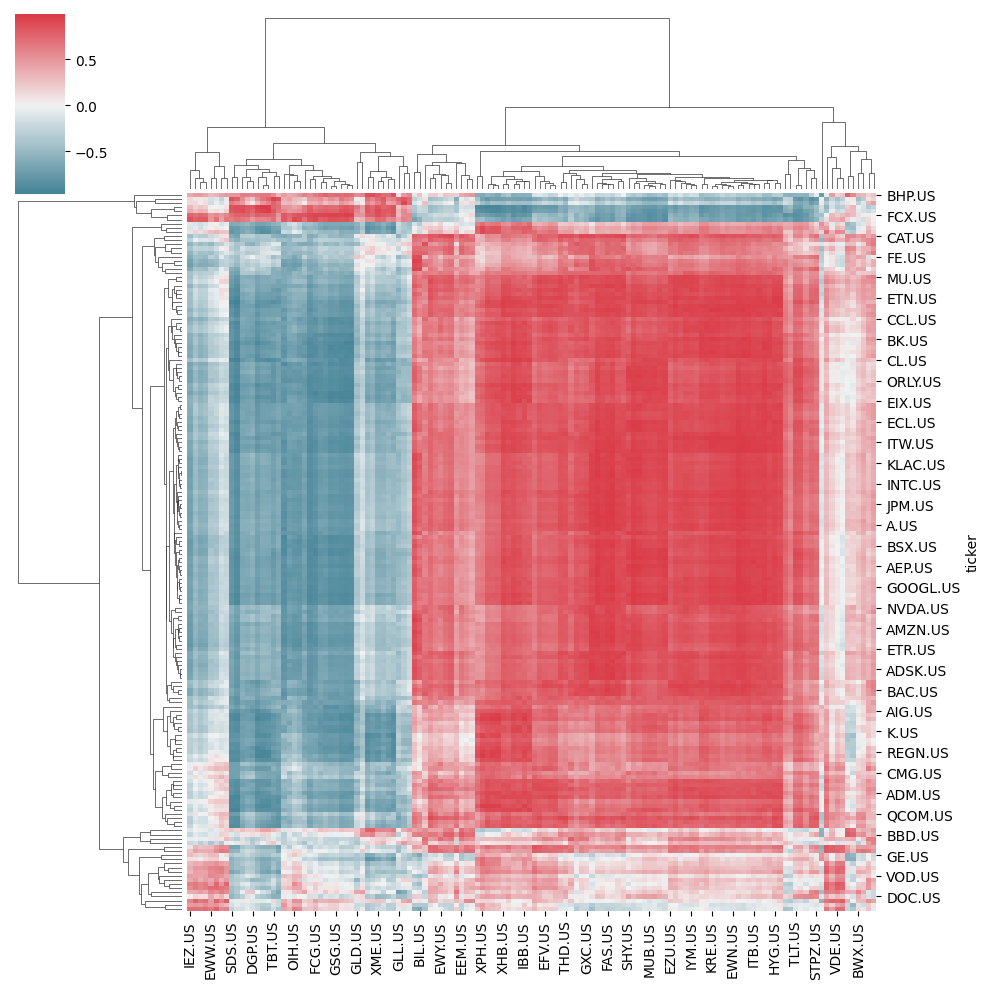

In [26]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.clustermap(corr, cmap=cmap, center=0);

## Candidate Selection using Heuristics

### Computational Complexity: Comparing running times

In this section, we compare the running times of various cointegration tests. More specifically, we are running tests for a single asset vs. the remaining set of securities.

#### Prepare Data

In [27]:
stocks.shape, etfs.shape

((2516, 174), (2516, 132))

In [28]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 174 entries, AAPL.US to SBAC.US
dtypes: float64(174)
memory usage: 3.4 MB


In [29]:
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 132 entries, SPY.US to VNM.US
dtypes: float64(132)
memory usage: 2.6 MB


In [30]:
security = etfs['AAXJ.US'].loc['2010': '2013']
candidates = stocks.loc['2010': '2013']

In [31]:
security = security.div(security.iloc[0])
candidates = candidates.div(candidates.iloc[0])
spreads = candidates.sub(security, axis=0)

In [32]:
n, m = spreads.shape
X = np.ones(shape=(n, 2))
X[:, 1] = np.arange(1, n+1)

#### Heuristics

In [33]:
%%timeit
np.linalg.inv(X.T @ X) @ X.T @ spreads

902 μs ± 93.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [34]:
%%timeit
spreads.std()

1.19 ms ± 163 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [35]:
%%timeit
candidates.corrwith(security)

70.5 ms ± 9.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Cointegration Tests

In [36]:
%%timeit
for candidate, prices in candidates.items():
    df = pd.DataFrame({'s1': security,
                       's2': prices})
    var = VAR(df.values)
    lags = var.select_order()
    k_ar_diff = lags.selected_orders['aic']
    coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)
    coint(security, prices, trend='c')[:2]
    coint(prices, security, trend='c')[:2]

44.2 s ± 1.35 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Clearly, cointegration tests are significantly more costly. It would be great if the heuristics worked just as well, or at least 'good enough'.

### Compute Heuristics

The function `compute_pair_metrics()` computes the following distance metrics for over 23,000 pairs of
stocks and Exchange Traded Funds (ETFs) for 2010-14 and 2015-19:

- The **drift of the spread**, defined as a linear regression of a time trend on the spread
- The spread's  **volatility**
- The **correlations** between the normalized price series and between their returns

Low drift and volatility, as well as high correlation, are simple proxies for cointegration. 

To evaluate the predictive power of these heuristics, we also run Engle-Granger and Johansen **cointegration tests** using `statsmodels` for the preceding pairs. This takes place in the loop in the second half of `compute_pair_metrics()`.

We first estimate the optimal number of lags that we need to specify for the Johansen test. For both tests, we assume that the cointegrated series (the spread) may have an intercept different from zero but no trend:

In [37]:


def compute_pair_metrics(security, 
                         candidates):
    security = security.div(security.iloc[0])
    ticker = security.name
    candidates = candidates.div(candidates.iloc[0])
    spreads = candidates.sub(security, axis=0)
    n, m = spreads.shape
    X = np.ones(shape=(n, 2))
    X[:, 1] = np.arange(1, n + 1)
    
    # compute drift
    drift = ((np.linalg.inv(X.T @ X) @ X.T @ spreads).iloc[1]
             .to_frame('drift'))
    
    # compute volatility
    vol = spreads.std().to_frame('vol')
    
    # return correlation
    corr_ret = (candidates.pct_change()
                .corrwith(security.pct_change())
                .to_frame('corr_ret'))
    
    # normalized price series correlation
    corr = candidates.corrwith(security).to_frame('corr')
    metrics = drift.join(vol).join(corr).join(corr_ret).assign(n=n)
    
    tests = []
    # run cointegration tests
    for candidate, prices in tqdm(candidates.items()):
        df = pd.DataFrame({'s1': security, 's2': prices})
        var = VAR(df.values)
        lags = var.select_order() # select VAR order
        k_ar_diff = lags.selected_orders['aic']
        # Johansen Test with constant Term and estd. lag order
        cj0 = coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)
        # Engle-Granger Tests
        t1, p1 = coint(security, prices, trend='c')[:2]
        t2, p2 = coint(prices, security, trend='c')[:2]
        tests.append([ticker, candidate, t1, p1, t2, p2, 
                      k_ar_diff, *cj0.lr1])
    columns = ['s1', 's2', 't1', 'p1', 't2', 'p2', 'k_ar_diff', 'trace0', 'trace1']
    tests = pd.DataFrame(tests, columns=columns).set_index('s2')
    return metrics.join(tests)

In [43]:
spreads = []
start = 2010
stop = 2019
etf_candidates = etfs.loc[str(start): str(stop), :]
stock_candidates = stocks.loc[str(start): str(stop), :]
s = time()
for i, (etf_ticker, etf_prices) in enumerate(etf_candidates.items(), 1):
    df = compute_pair_metrics(etf_prices, stock_candidates)
    spreads.append(df.set_index('s1', append=True))
    if i % 10 == 0:
        print(f'\n{i:>3} {time() - s:.1f}\n')
        s = time()

174it [02:05,  1.39it/s]
174it [01:56,  1.50it/s]
174it [01:52,  1.55it/s]
174it [01:53,  1.53it/s]
174it [01:54,  1.52it/s]
174it [01:54,  1.52it/s]
174it [01:54,  1.53it/s]
174it [02:49,  1.03it/s]
174it [02:09,  1.34it/s]
174it [01:59,  1.46it/s]



 10 1230.6



174it [01:53,  1.54it/s]
174it [01:53,  1.54it/s]
174it [02:05,  1.38it/s]
174it [02:55,  1.01s/it]
174it [01:58,  1.47it/s]
174it [01:52,  1.55it/s]
174it [01:52,  1.55it/s]
174it [01:52,  1.55it/s]
174it [02:48,  1.03it/s]
174it [02:28,  1.17it/s]



 20 1301.5



174it [01:53,  1.54it/s]
174it [01:51,  1.56it/s]
174it [03:25,  1.18s/it]
174it [03:08,  1.08s/it]
174it [01:53,  1.53it/s]
174it [01:54,  1.52it/s]
174it [02:03,  1.41it/s]
174it [01:53,  1.53it/s]
174it [02:56,  1.02s/it]
174it [01:54,  1.52it/s]



 30 1376.9



174it [01:53,  1.53it/s]
174it [02:44,  1.06it/s]
174it [02:44,  1.06it/s]
174it [01:54,  1.52it/s]
174it [01:57,  1.48it/s]
174it [02:01,  1.43it/s]
174it [03:00,  1.04s/it]
174it [03:14,  1.12s/it]
174it [03:16,  1.13s/it]
174it [02:12,  1.31it/s]



 40 1502.7



174it [02:00,  1.44it/s]
174it [01:58,  1.47it/s]
174it [02:18,  1.25it/s]
174it [03:19,  1.15s/it]
174it [03:15,  1.12s/it]
174it [03:09,  1.09s/it]
174it [03:15,  1.12s/it]
174it [03:09,  1.09s/it]
174it [01:58,  1.47it/s]
174it [02:01,  1.43it/s]



 50 1590.9



174it [02:09,  1.34it/s]
174it [02:23,  1.22it/s]
174it [03:26,  1.19s/it]
174it [02:12,  1.31it/s]
174it [02:00,  1.45it/s]
174it [02:51,  1.01it/s]
174it [03:14,  1.12s/it]
174it [03:10,  1.10s/it]
174it [03:18,  1.14s/it]
174it [02:42,  1.07it/s]



 60 1652.0



174it [02:00,  1.45it/s]
174it [02:00,  1.45it/s]
174it [02:00,  1.45it/s]
174it [02:14,  1.30it/s]
174it [03:18,  1.14s/it]
174it [03:04,  1.06s/it]
174it [02:11,  1.32it/s]
174it [01:59,  1.46it/s]
174it [02:34,  1.13it/s]
174it [03:18,  1.14s/it]



 70 1487.6



174it [03:16,  1.13s/it]
174it [03:07,  1.08s/it]
174it [02:55,  1.01s/it]
174it [02:01,  1.44it/s]
174it [01:55,  1.50it/s]
174it [01:56,  1.50it/s]
174it [01:56,  1.49it/s]
174it [01:57,  1.48it/s]
174it [01:57,  1.48it/s]
174it [01:56,  1.49it/s]



 80 1382.1



174it [01:52,  1.55it/s]
174it [01:50,  1.57it/s]
174it [01:52,  1.54it/s]
174it [01:56,  1.49it/s]
174it [01:51,  1.56it/s]
174it [01:56,  1.49it/s]
174it [01:57,  1.48it/s]
174it [01:55,  1.50it/s]
174it [01:51,  1.55it/s]
174it [01:50,  1.58it/s]



 90 1138.1



174it [01:53,  1.53it/s]
174it [01:52,  1.55it/s]
174it [01:52,  1.54it/s]
174it [01:52,  1.55it/s]
174it [01:52,  1.54it/s]
174it [01:59,  1.45it/s]
174it [01:57,  1.49it/s]
174it [01:57,  1.48it/s]
174it [01:50,  1.57it/s]
174it [01:56,  1.50it/s]



100 1146.4



174it [01:53,  1.53it/s]
174it [01:53,  1.53it/s]
174it [01:52,  1.54it/s]
174it [01:57,  1.48it/s]
174it [01:58,  1.47it/s]
174it [01:52,  1.55it/s]
174it [01:52,  1.55it/s]
174it [01:51,  1.56it/s]
174it [01:55,  1.50it/s]
174it [01:54,  1.52it/s]



110 1143.6



174it [01:52,  1.54it/s]
174it [01:51,  1.56it/s]
174it [02:02,  1.42it/s]
174it [01:50,  1.57it/s]
174it [01:49,  1.58it/s]
174it [02:52,  1.01it/s]
174it [01:53,  1.53it/s]
174it [01:42,  1.69it/s]
174it [01:41,  1.71it/s]
174it [01:42,  1.70it/s]



120 1162.5



174it [01:41,  1.71it/s]
174it [01:42,  1.70it/s]
174it [01:42,  1.70it/s]
174it [01:41,  1.71it/s]
174it [01:42,  1.70it/s]
174it [01:40,  1.72it/s]
174it [01:41,  1.72it/s]
174it [01:41,  1.71it/s]
174it [01:41,  1.71it/s]
174it [01:43,  1.67it/s]



130 1021.1



174it [01:41,  1.71it/s]
174it [01:41,  1.71it/s]


In [44]:
names = get_ticker_dict()
spreads = pd.concat(spreads)
spreads.index.names = ['s2', 's1']
spreads = spreads.swaplevel()
spreads['name1'] = spreads.index.get_level_values('s1').map(names)
spreads['name2'] = spreads.index.get_level_values('s2').map(names)

In [45]:
spreads['t'] = spreads[['t1', 't2']].min(axis=1)
spreads['p'] = spreads[['p1', 'p2']].min(axis=1)

### Engle-Granger vs Johansen: how do their findings compare?

To check for the significance of the cointegration tests, we compare the Johansen trace statistic for rank 0 and 1 to their respective critical values and obtain the Engle-Granger p-value.

We follow the recommendation by Gonzalo and Lee (1998) to apply both tests and accept pairs where they agree. The authors suggest additional due diligence in case of disagreement, which we are going to skip.

In [46]:
spreads['trace_sig'] = ((spreads.trace0 > trace0_cv) &
                        (spreads.trace1 > trace1_cv)).astype(int)
spreads['eg_sig'] = (spreads.p < .05).astype(int)

For the over 46,000 pairs across both sample periods, the Johansen test considers 3.2 percent of the relationships as significant, while the Engle-Granger considers 6.5 percent. They agree on 366 pairs (results may change with new data downloaded from stooq).

In [47]:
pd.crosstab(spreads.eg_sig, spreads.trace_sig)

trace_sig,0,1
eg_sig,,
0,20716,631
1,1452,169


In [48]:
spreads['coint'] = (spreads.trace_sig & spreads.eg_sig).astype(int)

In [49]:
spreads.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 22968 entries, ('SPY.US', 'AAPL.US') to ('VNM.US', 'SBAC.US')
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   drift      22968 non-null  float64
 1   vol        22968 non-null  float64
 2   corr       22968 non-null  float64
 3   corr_ret   22968 non-null  float64
 4   n          22968 non-null  int64  
 5   t1         22968 non-null  float64
 6   p1         22968 non-null  float64
 7   t2         22968 non-null  float64
 8   p2         22968 non-null  float64
 9   k_ar_diff  22968 non-null  int64  
 10  trace0     22968 non-null  float64
 11  trace1     22968 non-null  float64
 12  name1      22968 non-null  object 
 13  name2      22968 non-null  object 
 14  t          22968 non-null  float64
 15  p          22968 non-null  float64
 16  trace_sig  22968 non-null  int32  
 17  eg_sig     22968 non-null  int32  
 18  coint      22968 non-null  int32  
dtypes: float64

In [50]:
spreads = spreads.reset_index()

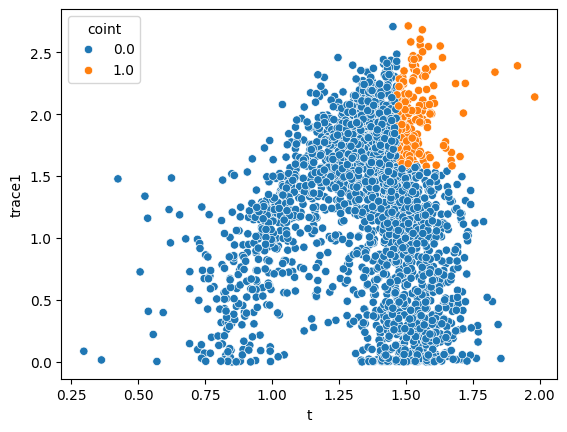

In [51]:
sns.scatterplot(x=np.log1p(spreads.t.abs()), 
                y=np.log1p(spreads.trace1), 
                hue='coint', data=spreads[spreads.trace0>trace0_cv]);

In [52]:
spreads.to_hdf('heuristics.h5', 'spreads')

In [53]:
spreads = pd.read_hdf('heuristics.h5', 'spreads')

### Evaluate Heuristics

In [54]:
spreads.drift = spreads.drift.abs()

In [55]:
pd.crosstab(spreads.eg_sig, spreads.trace_sig)

trace_sig,0,1
eg_sig,,
0,20716,631
1,1452,169


In [56]:
pd.set_option('display.float_format', lambda x: f'{x:.2%}')
pd.crosstab(spreads.eg_sig, spreads.trace_sig, normalize=True)

trace_sig,0,1
eg_sig,,
0,90.20%,2.75%
1,6.32%,0.74%


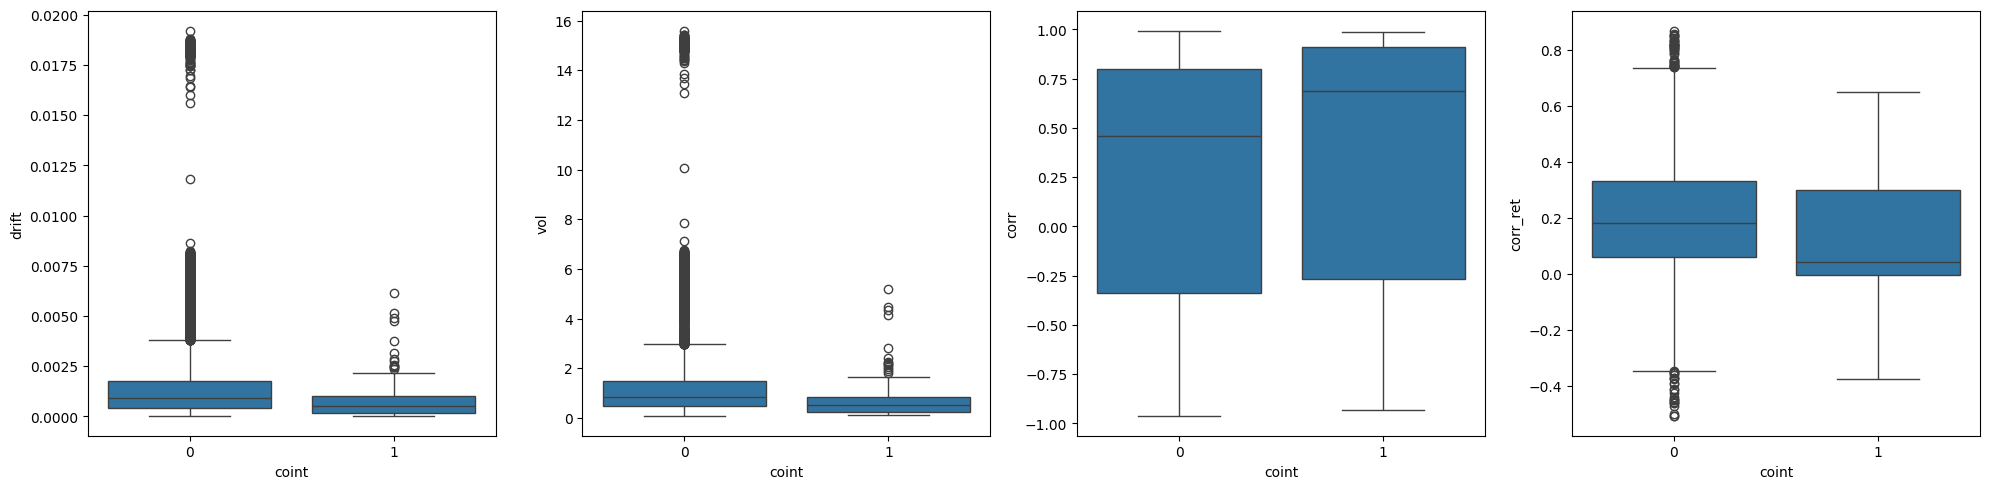

In [57]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
for i, heuristic in enumerate(['drift', 'vol', 'corr', 'corr_ret']):
    sns.boxplot(x='coint', y=heuristic, data=spreads, ax=axes[i])
fig.tight_layout();

### How well do the heuristics predict significant cointegration?

When we compare the distributions of the heuristics for series that are cointegrated according to both tests with the remainder that is not, volatility and drift are indeed lower (in absolute terms). Figure 9.14 shows that the picture is less clear for the two correlation measures:

In [58]:
spreads.groupby(spreads.coint)['drift', 'vol', 'corr'].describe().stack(level=0).swaplevel().sort_index()

ValueError: Cannot subset columns with a tuple with more than one element. Use a list instead.

In [59]:
spreads.coint.value_counts()

coint
0    22799
1      169
Name: count, dtype: int64

#### Logistic Regression

To evaluate the predictive accuracy of the heuristics, we first run a logistic regression model with these features to predict significant cointegration. It achieves an area-under-the-curve (AUC) cross-validation score of 0.815; excluding the correlation metrics, it still scores 0.804. A decision tree does slightly better at AUC=0.821, with or without the correlation features.

In [ ]:
y = spreads.coint
X = spreads[['drift', 'vol', 'corr', 'corr_ret']]
# X = spreads[['drift', 'vol']]

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

In [ ]:
log_reg = LogisticRegressionCV(Cs=np.logspace(-10, 10, 21), 
                               class_weight='balanced',
                               scoring='roc_auc')

In [ ]:
log_reg.fit(X=X, y=y)
Cs = log_reg.Cs_
scores = pd.DataFrame(log_reg.scores_[True], columns=Cs).mean()
scores.plot(logx=True);
f'C:{np.log10(scores.idxmax()):.2f}, AUC: {scores.max():.2%}'

In [ ]:
log_reg.coef_

In [ ]:
y_pred = log_reg.predict_proba(X)[:, 1]
confusion_matrix(y_true=spreads.coint, y_pred=(y_pred>.5))

In [ ]:
spreads.assign(y_pred=log_reg.predict_proba(X)[:, 1]).groupby(spreads.coint).y_pred.describe()

Not least due to the strong class imbalance, there are large numbers of false positives:
correctly identifying 80 percent of the 366 cointegrated pairs implies over 16,500 false positives, but eliminates almost 30,000 of the candidates. See the notebook cointegration_
tests for additional detail.

The **key takeaway** is that distance heuristics can help screen a large universe more  efficiently, but this comes at a cost of missing some cointegrated pairs and still requires
substantial testing.

#### Decision Tree Classifier

In [ ]:
model = DecisionTreeClassifier(class_weight='balanced')
decision_tree = GridSearchCV(model,
                             param_grid={'max_depth': list(range(1, 10))},
                             cv=5,
                             scoring='roc_auc')

In [ ]:
decision_tree.fit(X=X, y=y)

In [ ]:
f'{decision_tree.best_score_:.2%}, Depth: {decision_tree.best_params_["max_depth"]}'

In [ ]:
pd.Series(data=decision_tree.best_estimator_.feature_importances_, 
          index=X.columns).sort_values().plot.barh(title='Feature Importance')
sns.despine();

In [ ]:
spreads.assign(y_pred=decision_tree.predict_proba(X)[:, 1]).groupby(spreads.coint).y_pred.describe()

In [ ]:
sns.catplot(x='coint', 
            y='y_pred', 
            data=spreads.assign(y_pred=decision_tree.predict_proba(X)[:, 1]), 
            kind='box');